In [88]:
from lmfit import minimize, Parameters, fit_report
import lmfit
import pandas as pd
import tellurium as te
import numpy as np

import matplotlib.pyplot as plt

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
from emll.aesara_utils import LeastSquaresSolve

1. define the equation
2. fill out all the matrices
    - import the data
3. use lmfit to  fit the equation


In [24]:
# import the data 
df = pd.read_csv('data/twostep_1.05.csv')

In [89]:
r = te.loada('twostep.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

In [90]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

In [91]:
v_star = df[fluxes].loc[0]

In [ ]:
ex = r.getScaledElasticityMatrix()
ex

In [93]:
a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

### testing with multiple perturbations

In [121]:
en = df[enzymes].loc[1:]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(internal)]/df[internal].loc[0]
yn = df[external].iloc[-(len(external)):]/df[external].loc[0]
vn = df[fluxes].loc[1:]/df[fluxes].loc[0]

In [36]:
gt_fluxes = df[fluxes].loc[1:].values
inner = np.ones((2,2)) + ex@np.log(xn).T # + ey@np.log(yn).T
linlog_fluxes = (np.diag(v_star) @ inner).T

res = linlog_fluxes - gt_fluxes
(res*res).sum().sum()

0.035936982993467315

### using lmfit to predict elasticity values 

In [82]:
np.diag(v_star)

array([[2.74406307, 0.        ],
       [0.        , 2.74406307]])

In [87]:
def cb(params, iter, resid, *args, **kws):
    print(iter, (resid**2).sum().sum())

def residual(params, xn, yn, ey, v_star, df, *args, **kws):
    
    some_list = []
    Ex_params = [i for i in params if 'Ex' in i]
    for i in Ex_params:
        some_list.append(params[i])
    ex = np.asarray(some_list).reshape((2,1))

    #some_list = []
    #Ey_params = [i for i in params if 'Ey' in i]
    #for i in Ey_params:
    #    some_list.append(params[i])
    #ey = np.asarray(some_list).reshape((2,2)) 

    # a = 1.05 * np.diag(v_star)
    a = (.05 * np.diag(v_star)) + (v_star[0]*np.ones((2,2)))# 1.05 * np.diag(v_star))

    
    bb = np.ones((2,2))
    cc = ex@(np.log10(xn)).T
    dd = ey@(np.log(yn)).T

    b = (bb + cc)   

    model = a*b

    print(a)
    #print((df[fluxes].loc[1:].values-model.T).values.flatten())
    return ((df[fluxes].loc[1:].values-model.T).values.flatten())

params = Parameters()

for i in range(2*(1)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)
#for i in range(2*(2)):
#    params.add('Ey'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, yn, ey, v_star, df))#, iter_cb=cb)
# out = minimize(residual, params, args=(xn, yn, v_star, df), method='differential_evolution', iter_cb=cb, kws={'itervalues': itervalues})

[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]
[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]


In [ ]:
[2.88 0]
[0, 2.77] for matrix multiplication. 

In [79]:
out.params

name,value,standard error,relative error,initial value,min,max,vary
Ex0,-1.36957736,0.00688842,(0.50%),0,-10.0000000,10.0000000,True
Ex1,1.73063148,0.00688792,(0.40%),0,-10.0000000,10.0000000,True


In [80]:
r.getScaledElasticityMatrix()[0]/r.getScaledElasticityMatrix()[1]

[-0.79113193]

In [81]:
-1.36957736	/1.73063148

-0.7913743485123708

In [13]:
out.chisqr

0.018013588719158157

## Ex values predicted by lmfit when guesses were initialized at 0

In [14]:
Ex_values = [out.params.get(i).value for i in params if 'Ex' in i]
Ey_values = [out.params.get(i).value for i in params if 'Ey' in i]
Ex_values = np.array(Ex_values).reshape((2,1))
Ey_values = np.array(Ey_values).reshape((2,2))

In [15]:
pd.DataFrame(Ex_values, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())

,S1
J1,0.079925
J2,0.079925


## Ey values predicted by lmfit when guesses were initialized at 0

In [16]:
pd.DataFrame(Ey_values, index=r.getReactionIds())

,0,1
J1,0.321506,-0.334662
J2,0.321506,-0.334662


## Trying to see if we can get lmfit to predict the actual elasticity values by initializing the guesses with ground truth

In [17]:
# flatten the matrix 
ex_seeds = r.getScaledElasticityMatrix().flatten()
ey_seeds = ey.flatten()

s_params = Parameters()

for i in range(2*(1)):
    s_params.add('Ex'+str(i), value=ex_seeds[i]+ 0.05*ex_seeds[i], min=-10, max=10)
for i in range(2*(2)):
    s_params.add('Ey'+str(i), value=ey_seeds[i]+ 0.05*ey_seeds[i], min=-10, max=10)

s_out = minimize(residual, s_params, args=(xn, yn, v_star, df))

In [18]:
s_out.chisqr

0.018013588719158098

## Ex values predicted by lmfit when guesses were initialized with ground truth elasticity values

In [19]:
s_Ex_values = [s_out.params.get(i).value for i in params if 'Ex' in i]
s_Ey_values = [s_out.params.get(i).value for i in params if 'Ey' in i]
s_Ex_values = np.array(s_Ex_values).reshape((2,1))
s_Ey_values = np.array(s_Ey_values).reshape((2,2))

In [20]:
pd.DataFrame(s_Ex_values, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())

,S1
J1,0.079925
J2,0.079925


## Ey values predicted by lmfit when guesses were initialized with ground truth elasticity values

In [21]:
pd.DataFrame(s_Ey_values, index=r.getReactionIds())

,0,1
J1,0.321506,-0.334662
J2,0.321506,-0.334662


## Calculating the chi square of the ground truth values in the loss function

In [22]:
((linlog_fluxes - gt_fluxes)*(linlog_fluxes - gt_fluxes)).sum().sum()

0.03593703407887569

In [23]:
s_out.chisqr # <-- lmfit found a way to minimize the loss function even more with different values

0.018013588719158098

## Calculating the values of chi-square while varying the number of Ex values fit, given Ey. 

In [24]:
r = te.loada('twostep.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

In [25]:
en = df[enzymes].loc[1:]/df[enzymes].loc[0]
xn = df[internal].loc[1:]/df[internal].loc[0]
yn = df[external].loc[1:]/df[external].loc[0]
vn = df[fluxes].loc[1:]/df[fluxes].loc[0]

In [26]:
ex = r.getScaledElasticityMatrix()
a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

In [27]:
# where does the ground truth have nonzero values?
nonzeros = np.where(r.getScaledElasticityMatrix().flatten()!=0)[0]
ex_seeds = r.getScaledElasticityMatrix().flatten()

In [28]:
def cb(params, iter, resid, *args, **kws):
    print(iter, (resid**2).sum().sum())

def residual(params, xn, yn, v_star, ex, ey, df, coords, *args, **kws):

    for i in coords:
        ex[i] = params[f'Ex{i}']

    ex = ex.reshape((2,1))
    a = np.ones((2,4))
    b = ex@np.log(xn).T
    c = ey@np.log(yn).T

    model = np.diag(v_star)@(a + b + c)
    return (df[fluxes].loc[1:].values-model.T)

In [29]:
chisq_list=[]
param_list = []
# for each nonzero elasticity
for i in range(len(nonzeros)):
    # for each elasticity up to that nonzero elasticity
    params = Parameters()
    for ii in nonzeros[:(i+1)]:
        # define parameters for the run
        # add all the nonzero parameters
        params.add(f'Ex{ii}', value=ex_seeds[ii], min=-10, max=10)
    coords = [ii for ii in nonzeros[:(i+1)]]
    # out = minimize(residual, params, args=(xn, yn, v_star, ex.flatten(), ey, df, coords), method='differential_evolution', iter_cb=cb)
    out = minimize(residual, params, args=(xn, yn, v_star, ex.flatten(), ey, df, coords))
    chisq_list.append(out.chisqr)
    param_list.append(out.params)

In [30]:
len(chisq_list)

2

Text(0, 0.5, 'chisqr')

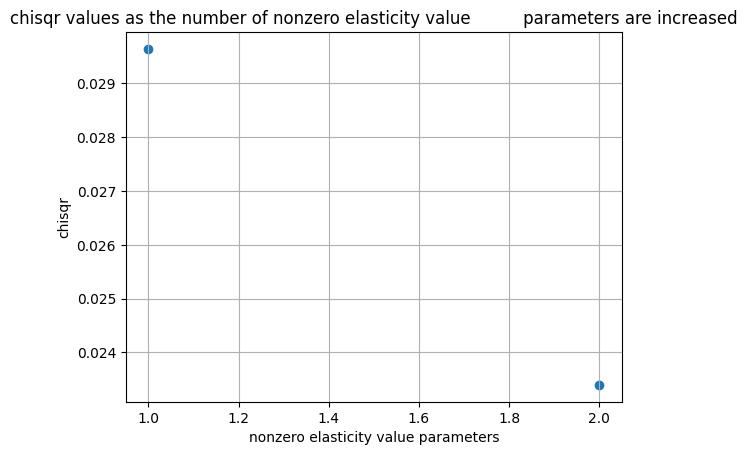

In [31]:
plt.figure()
plt.scatter(np.arange(1,3,1), np.array(chisq_list))
plt.grid()
plt.title('chisqr values as the number of nonzero elasticity value\
          parameters are increased')
plt.xlabel('nonzero elasticity value parameters')
plt.ylabel('chisqr')


In [33]:
param_list[1]

name,value,standard error,relative error,initial value,min,max,vary
Ex0,-0.12264508,0.37158304,(302.97%),-0.5948331537319074,-10.0000000,10.0000000,True
Ex1,0.28161887,0.37158304,(131.95%),0.7518760568558508,-10.0000000,10.0000000,True


In the results above, ey was fixed and ex parameters were initialized with groundtruth values. 

Now, we are going to explore control coefficient values for each set of elasticity values predicted by lmfit

In [34]:
# copy+pasted then adapted from BMCA-pipeline/util

n_exp = en.shape[0]

e_star = df[enzymes].iloc[0].values
x_star = df[internal].iloc[0].values
y_star = df[external].iloc[0].values
v_star = df[fluxes].iloc[0].values

def elasticity_to_CCC(BMCA, scaledE=None):

    if scaledE is None:
        scaledE = BMCA.Ex

    r = te.loada(BMCA.model_file)
    r.conservedMoietyAnalysis = True
    r.steadyState()
    link_matrix = r.getLinkMatrix()
    Nr = r.getReducedStoichiometryMatrix()

    ##### this line needs to be workshopped
    unscaledE = np.linalg.inv(np.diag(1/BMCA.v_star)) @ scaledE @ np.linalg.inv(np.diag(BMCA.x_star))

    invJac = np.linalg.inv(-Nr@unscaledE@link_matrix)
    idMat = np.identity(len(BMCA.v_star))

    # unscaled concentration and flux control coefficients, respectively
    Cx = link_matrix@invJac@Nr 
    CJ = np.matmul(unscaledE, Cx) + idMat # unscaled FCC

    # scaled concentration and flux control coefficients, respectively  
    ##### these two lines need to be workshopped
    CxS = np.diag(1/BMCA.x_star) @ Cx @ np.diag(BMCA.v_star)
    CJS = np.diag(1/BMCA.v_star) @ CJ @ np.diag(BMCA.v_star)

    return CxS, CJS

def estimate_CCs(Ex):
    vn[vn == 0] = 1e-6
    
    a = np.diag(en.values / vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1, axis=0)

    Ex_ss = a @ Ex
    As = N @ np.diag(v_star) @ Ex_ss
    bs = N @ np.diag(v_star)
    bs = bs[np.newaxis, :].repeat(1, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(N.T))
    identity = identity[np.newaxis,:].repeat(1, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return FCC

In [35]:
# [[i[ii].value for ii in i.keys()] for i in param_list]
lmfit_values = [param_list[-1][ii].value for ii in param_list[-1].keys()]
ex = r.getScaledElasticityMatrix()
FCC_list = []

for i in param_list:
    # make replacement in groundtruth ex at the proper location
    
    ex_replaced = ex.flatten()
    for ii in nonzeros[:len(param_list[0].keys())]:
        ex_replaced[ii] = lmfit_values[ii]
    ex_replaced = ex_replaced.reshape((2,1))
    FCC_list.append(estimate_CCs(ex_replaced))

In [36]:
fcc_list=np.array(FCC_list)
fcc_list = fcc_list.squeeze()

In [37]:
fcc_list[0][0]

array([ 1.13955802, -0.13955802])

In [38]:
fcc_list[1][0]

array([ 1.13955802, -0.13955802])

In [39]:
r.getScaledFluxControlCoefficientMatrix()[0]

[0.55830617 0.44169383]

the FCC values are all the same for each lmfit run. 

Could this be due to the fact that the Ex values were all the same for each lmfit run? 

## Using a stochastic method

In [40]:
chisq_list=[]
param_list = []
# for each nonzero elasticity
for i in range(len(nonzeros)):
    # for each elasticity up to that nonzero elasticity
    params = Parameters()
    for ii in nonzeros[:(i+1)]:
        # define parameters for the run
        # add all the nonzero parameters
        params.add(f'Ex{ii}', value=ex_seeds[ii], min=-10, max=10)
    coords = [ii for ii in nonzeros[:(i+1)]]
    
    out = minimize(residual, params, args=(xn, yn, v_star, ex.flatten(), ey, df, coords), method='differential_evolution')
    chisq_list.append(out.chisqr)
    param_list.append(out.params)

In [41]:
param_list[0]

name,value,initial value,min,max,vary
Ex0,-0.12264508,-0.5948331537319074,-10.0000000,10.0000000,True


In [42]:
param_list[1]

name,value,initial value,min,max,vary
Ex0,-0.12264512,-0.5948331537319074,-10.0000000,10.0000000,True
Ex1,0.28161841,0.7518760568558508,-10.0000000,10.0000000,True


Text(0, 0.5, 'chisqr')

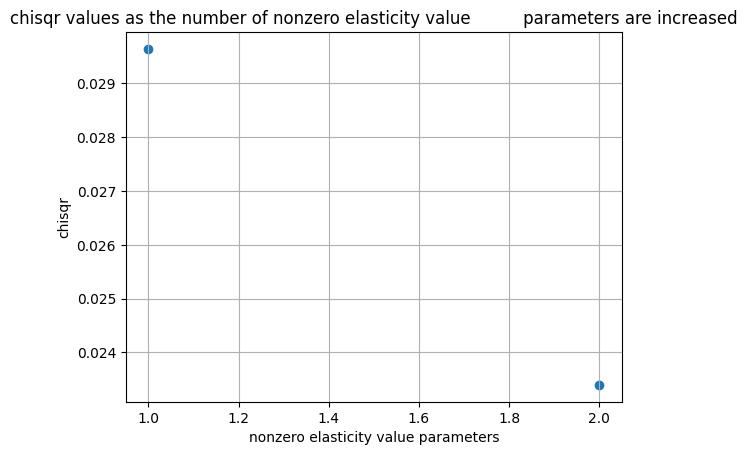

In [43]:
plt.figure()
plt.scatter(np.arange(1,3,1), np.array(chisq_list))
plt.grid()
plt.title('chisqr values as the number of nonzero elasticity value\
          parameters are increased')
plt.xlabel('nonzero elasticity value parameters')
plt.ylabel('chisqr')


In [44]:
# [[i[ii].value for ii in i.keys()] for i in param_list]
lmfit_values = [param_list[-1][ii].value for ii in param_list[-1].keys()]
ex = r.getScaledElasticityMatrix()
FCC_list = []

for i in param_list:
    # make replacement in groundtruth ex at the proper location
    
    ex_replaced = ex.flatten()
    for ii in nonzeros[:len(param_list[0].keys())]:
        ex_replaced[ii] = lmfit_values[ii]
    ex_replaced = ex_replaced.reshape((2,1))
    FCC_list.append(estimate_CCs(ex_replaced))

In [45]:
fcc_list=np.array(FCC_list)
fcc_list = fcc_list.squeeze()

In [46]:
fcc_list[1]

array([[ 1.13955806, -0.13955806],
       [-0.86044194,  1.86044194]])

In [47]:
fcc_list[0]

array([[ 1.13955806, -0.13955806],
       [-0.86044194,  1.86044194]])